# 1. Environment

In [1]:
%matplotlib inline
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd
from PIL import Image
import random
import seaborn as sns
from tqdm import tqdm_notebook as tqdm
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.models as models
from torchvision import transforms
from sklearn.model_selection import train_test_split
import multiprocessing
import gc
from albumentations import (Compose, ShiftScaleRotate, RGBShift, Cutout, RandomCrop, PadIfNeeded, Resize)
import cv2
import sys
sys.path.append("..")

In [2]:
from kuzushiji.resnet_model import CharacterResnet

In [3]:
sns.set(style="darkgrid", context="notebook", palette="muted")

In [4]:
# seed = 7
# random.seed(seed)
# np.random.seed(seed)
# torch.manual_seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True
#     torch.backends.cudnn.benchmark = False

# 2. Load

In [5]:
input_path = Path("../input")
train_imgs_path = input_path / "train_images"
print("Train Images:%d" % len(list(train_imgs_path.glob("*jpg"))))
train = pd.read_csv("../input/train.csv")

Train Images:3881


# 3. Feature Engineering

## Check Training Images

In [6]:
train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3881 entries, 0 to 3880
Data columns (total 2 columns):
image_id    3881 non-null object
labels      3605 non-null object
dtypes: object(2)
memory usage: 60.8+ KB


Some `labels` seem to contain `NaN` in `train`.  
We check showing top-6 images containing `NaN` at `labels`.

In [8]:
train_nan_labels = train[train["labels"].isnull()]
train_nan_labels.head(6)

,image_id,labels
66,100241706_00038_2,NaN
67,100241706_00039_1,NaN
68,100241706_00039_2,NaN
69,100241706_00040_1,NaN
73,100249371_00003_2,NaN
74,100249371_00004_1,NaN


In [9]:
train_nan_labels.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 276 entries, 66 to 3880
Data columns (total 2 columns):
image_id    276 non-null object
labels      0 non-null object
dtypes: object(2)
memory usage: 6.5+ KB


In [10]:
# fig = plt.figure(figsize=(20, 80))
# for i in range(6):
#     image_id = train_nan_labels["image_id"].iloc[i]
#     file_name = image_id + ".jpg"
#     train_img_path = train_imgs_path / file_name
#     train_img = np.asarray(Image.open(train_img_path))
#     fig.add_subplot(1, 6, i+1, title=file_name)
#     plt.axis("off")
#     plt.imshow(train_img)
# plt.show()

It seem to contain no characters in `NaN` label's images.  
Therefore, we can delete them all and reset the index.

In [11]:
train = train.dropna()
train = train.reset_index(drop=True)
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3605 entries, 0 to 3604
Data columns (total 2 columns):
image_id    3605 non-null object
labels      3605 non-null object
dtypes: object(2)
memory usage: 56.5+ KB


We use **3605** training images.

## Create Characters Data

In [12]:
train.head()

,image_id,labels
0,100241706_00004_2,U+306F 1231 3465 133 53 U+304C 275 1652 84 69 ...
1,100241706_00005_1,U+306F 1087 2018 103 65 U+304B 1456 1832 40 73...
2,100241706_00005_2,U+306F 572 1376 125 57 U+306E 1551 2080 69 68 ...
3,100241706_00006_1,U+3082 1455 3009 65 44 U+516B 1654 1528 141 75...
4,100241706_00007_2,U+309D 1201 2949 27 33 U+309D 1196 1539 27 36 ...


From [Data Description](https://www.kaggle.com/c/kuzushiji-recognition/data),

> The string should be read as space separated series of values where `Unicode character`, `X`, `Y`, `Width`, and `Height` are repeated as many times as necessary.

We create a dictionary `train_chars` where the key is `image_id` and the value is a dictionary containing `Unicode character`, `X`, `Y`, `Width` and `Height`.

In [13]:
train_chars = {}
uc_list = []
train_chars_num = 0
for i in tqdm(range(train.shape[0])):
    image_id = train.iloc[i]["image_id"]
    labels = train.iloc[i]["labels"].split(" ")
    values = {"Unicode" : [],
              "X" : [],
              "Y" : [],
              "Width" : [],
              "Height" : []}
    for j in range(0, len(labels), 5):
        uc = labels[j]
        x = int(labels[j+1])
        y = int(labels[j+2])
        w = int(labels[j+3])
        h = int(labels[j+4])
        uc_list.append(uc)
        values["Unicode"].append(uc)
        values["X"].append(x)
        values["Y"].append(y)
        values["Width"].append(w)
        values["Height"].append(h)
        train_chars_num += 1
    train_chars[image_id] = values
train_chars_num

683464

In [14]:
the_id = list(train_chars.keys())
the_id = the_id[0]
the_label = train_chars[the_id]
print(the_id)
print("({}, {}, {}, {})".format(the_label['X'][0],
                                the_label['Y'][0],
                                the_label['Width'][0],
                                the_label['Height'][0]))

100241706_00004_2
(1231, 3465, 133, 53)


In [15]:
def read_image(image_id, labels):
    image = Image.open('../input/train_images/{}.jpg'.format(image_id))
    xy_list = []
    labels_zip = zip(labels["Unicode"],
                     labels["X"],
                     labels["Y"],
                     labels["Width"],
                     labels["Height"])
    for uc, x, y, w, h in labels_zip:
        # Crop as Character's PIL Image
        char_img = image.crop((x, y, x+w, y+h))
        # Add Training Data
        char_img = np.asarray(char_img)
        xy_list.append((char_img, uc))
    return xy_list

In [16]:
%%time

pool = multiprocessing.Pool(processes=8)
result = []
for key, values in train_chars.items():
    result.append(pool.apply_async(read_image, (key, values,)))
pool.close()
pool.join()
char_uc_list = []
for res in result:
    xy_list = res.get()
    char_uc_list += xy_list

len(char_uc_list)

CPU times: user 4.99 s, sys: 4.8 s, total: 9.79 s
Wall time: 31.2 s


683464

In [17]:
image_size = []
for image_uc in char_uc_list:
    image_size.append(image_uc[0].shape)
image_size = np.array(image_size)

print(image_size[:,0].mean(), image_size[:,1].mean(), image_size[:,2].mean())
del image_size

94.93389556728664 77.20407804946566 3.0


We get **683464** character images(seems to be too large).  

## Check Unicodes

In [18]:
uc_trans = pd.read_csv(input_path / "unicode_translation.csv")
uc_trans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4787 entries, 0 to 4786
Data columns (total 2 columns):
Unicode    4787 non-null object
char       4787 non-null object
dtypes: object(2)
memory usage: 74.9+ KB


There are 4787 classes of all unicode characters.  
However, some characters might be useless in training images.  
We check useless unicodes which are in `uc_trans["Unicode"]` and are not in all unicodes of `train_chars`.

In [19]:
uc_list = set(uc_list)
uc_trans = uc_trans[uc_trans['Unicode'].isin(uc_list)]
uc_trans.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4212 entries, 5 to 4786
Data columns (total 2 columns):
Unicode    4212 non-null object
char       4212 non-null object
dtypes: object(2)
memory usage: 98.7+ KB


There seems to be 575 useless unicodes in training images.  
Finally, we shrink `uc_trans` from 4787 classes to **4212**(=4787-575).

We create a list of unicode `uc_list` whose index is used for training and test labels.

In [20]:
uc_list = uc_trans["Unicode"].values.tolist()
uc_list.index("U+306F")

84

# 4. Create Pytorch Dataset

We define `KuzushijiCharDataset` class extended from `torch.utils.data.Dataset`.  
As it costs little time to get i-th training data, it creates as follows.
1. Open PIL Image each `image_id`
2. Crop as Character's PIL Image
3. Resize Character's PIL Image
4. Gray-Scale Character's PIL Image where the channel is 1
5. Convert from Character's PIL Image to Tensor

In [21]:
class KuzushijiCharDataset(Dataset):
    def __init__(self,
                 data_list: list,
                 uc_list: list,
                 image_path: Path,
                 scale_resize: tuple,
                 transform=None):
        self._image_list = []
        self._y_list = []
        self.scale_resize = scale_resize
        self.transform = transform
                
        for image, uc in tqdm(data_list):
            self._image_list.append(image)
            # Add Training Label
            uc_idx = uc_list.index(uc)
            self._y_list.append(uc_idx)
            

    def __len__(self):
        return len(self._y_list)
    
    def __getitem__(self, idx: int):
        char_img = self._image_list[idx]
        
#         old_img = char_img.copy()
#         old_img = Image.fromarray(old_img)
#         old_img = old_img.resize(self.scale_resize)
#         old_img = transforms.functional.to_tensor(old_img)
        
#         if self.transform:
#             char_img = self.transform(image=char_img)['image']
#         else:
#             # Resize Character's PIL Image
#             char_img = Image.fromarray(char_img)
#             char_img = char_img.resize(self.scale_resize)

        char_img = self.transform(image=char_img)['image']
        # Convert to Tensor
        x = transforms.functional.to_tensor(char_img)
        y = self._y_list[idx]
        return x, y

Some width or height are too large.  
For the time being, we decide the resizing scale by fixed values(=48).

In [22]:
xy_train, xy_val = train_test_split(char_uc_list, test_size=0.1)
print(len(xy_train))
print(len(xy_val))

615117
68347


In [23]:
w_resize = 64
h_resize = 64

In [24]:
# 1. RGBShift
# 2. ShiftScaleRotate
# 3. Resize
# 3. Cutout

def train_augment(p=.5):
    return Compose([
        RGBShift(r_shift_limit=100, g_shift_limit=100, b_shift_limit=100, p=p),
        Cutout(num_holes=10, max_h_size=5, max_w_size=5, fill_value=0, p=p),
        PadIfNeeded(min_height=90, min_width=70, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
        RandomCrop(height=h_resize, width=w_resize, p=p),
        Resize(height=h_resize, width=w_resize, always_apply=True)
    ], p=p)

def valid_augment():
    return Compose([
        PadIfNeeded(min_height=90, min_width=70, border_mode=cv2.BORDER_CONSTANT, value=(0, 0, 0), always_apply=True),
        Resize(height=h_resize, width=w_resize, always_apply=True)
    ], p=1)

In [25]:
char_transform_train = train_augment()
char_transform_valid = valid_augment()

In [26]:
# for i_batch, sample_batched in enumerate(dataloaders['train']):
#     old_image, image, _ = sample_batched
#     image = np.array(image[0])
#     image = np.moveaxis(image, 0, 2)
#     plt.figure(figsize=(10, 10))
#     plt.title('new')
#     plt.imshow(image)
#     plt.show()

#     old_image = np.array(old_image[0])
#     old_image = np.moveaxis(old_image, 0, 2)
#     plt.figure(figsize=(10, 10))
#     plt.title("old")
#     plt.imshow(old_image)
#     plt.show()
#     break

# 5. Demonstration for Classifying Characters

In [27]:
def accuracy(outputs, labels):
    _, predicted = torch.max(outputs.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct / total

In [28]:
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR

In [29]:
def train(model, dataloaders, num_epochs, checkpoints_path):
    history = {'train': [], 'valid': []}
#     optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=0.001)
#     scheduler = ReduceLROnPlateau(optimizer, factor=0.15, patience=3)

    optimizer = torch.optim.SGD(model.parameters(), lr=1e-4, momentum=0.9, weight_decay=0.001)
    scheduler = CosineAnnealingLR(optimizer, T_max=3)

    criterion = torch.nn.CrossEntropyLoss()
    
    try:
        for epoch in range(num_epochs):
            print('Epoch {}/{}'.format(epoch + 1, num_epochs))

            for phase in ['train', 'valid']:
                metrics = {'loss': [], 'acc': []}
                torch.cuda.empty_cache()
                if phase == 'train':
                    model.train()  # Set model to training mode
                    for inputs, labels in tqdm(dataloaders[phase]):
                        inputs, labels = inputs.to(device), labels.to(device)
                        optimizer.zero_grad()
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        acc = accuracy(outputs, labels)
                        loss.backward()
                        optimizer.step()
                        metrics['loss'].append(loss.data.cpu().numpy())
                        metrics['acc'].append(acc)
                else:
                    model.eval()   # Set model to evaluate mode
                    with torch.no_grad():
                        for inputs, labels in tqdm(dataloaders[phase]):
                            inputs, labels = inputs.to(device), labels.to(device)
                            outputs = model(inputs)
                            loss = criterion(outputs, labels)
                            acc = accuracy(outputs, labels)
                            metrics['loss'].append(loss.data.cpu().numpy())
                            metrics['acc'].append(acc)
                history[phase].append({k: np.mean(metrics[k]) for k in metrics})
                print(phase, history[phase][-1])
            # scheduler.step(history['valid'][-1]['loss'])
            scheduler.step()
            torch.save(model.state_dict(), checkpoints_path.format(epoch))
    except KeyboardInterrupt:
        pass
    except:
        raise

    torch.save(model.state_dict(), checkpoints_path.format('final'))
    return model, history

## Create Network

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [31]:
resnet = models.resnet50(pretrained=True)
model = CharacterResnet(resnet)
model.load_state_dict(torch.load('../checkpoints/resnet50_start4.pth'))
model.to(device)
print(model)

CharacterResnet(
  (resnet_layer): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0)

## Define Training Parameters

In [32]:
max_epochs = 30
checkpoint_path = '../checkpoints/resnet50_{}.pth'
BATCH_SIZE = 512

dataloaders = {'train': DataLoader(KuzushijiCharDataset(data_list=xy_train,
                                                        uc_list=uc_list,
                                                        image_path=train_imgs_path,
                                                        scale_resize=(w_resize, h_resize),
                                                        transform=char_transform_train),
                                   batch_size=BATCH_SIZE,
                                   shuffle=True,
                                   num_workers=8),
               'valid': DataLoader(KuzushijiCharDataset(data_list=xy_val,
                                                        uc_list=uc_list,
                                                        image_path=train_imgs_path,
                                                        scale_resize=(w_resize, h_resize),
                                                        transform=char_transform_valid),
                                 batch_size=BATCH_SIZE,
                                 shuffle=False,
                                 num_workers=8)}

## Train

In [33]:
%%time

torch.cuda.empty_cache()
gc.collect()
model, history = train(model, dataloaders, max_epochs, checkpoint_path)

Epoch 1/30



train {'loss': 0.33499017, 'acc': 0.9329340977055518}



valid {'loss': 0.124525696, 'acc': 0.9791563689272761}
Epoch 2/30



train {'loss': 0.33141693, 'acc': 0.933876521536768}



valid {'loss': 0.124759264, 'acc': 0.979243822285485}
Epoch 3/30



train {'loss': 0.32935408, 'acc': 0.934498880486283}



valid {'loss': 0.12481664, 'acc': 0.9790980666884701}
Epoch 4/30



train {'loss': 0.33027813, 'acc': 0.9341121473103771}



valid {'loss': 0.12735432, 'acc': 0.979068915569067}
Epoch 5/30


CPU times: user 21min 40s, sys: 7min 46s, total: 29min 27s
Wall time: 29min 25s


In [34]:
history_tr = pd.DataFrame({'train_' + k: [metrics[k] for metrics in history['train']] for k in history['train'][0]})
history_val = pd.DataFrame({'val_' + k: [metrics[k] for metrics in history['valid']] for k in history['valid'][0]})
df_history = pd.concat([history_tr, history_val], 1)
df_history.to_csv('../cache/resnet_history.csv', index=False)

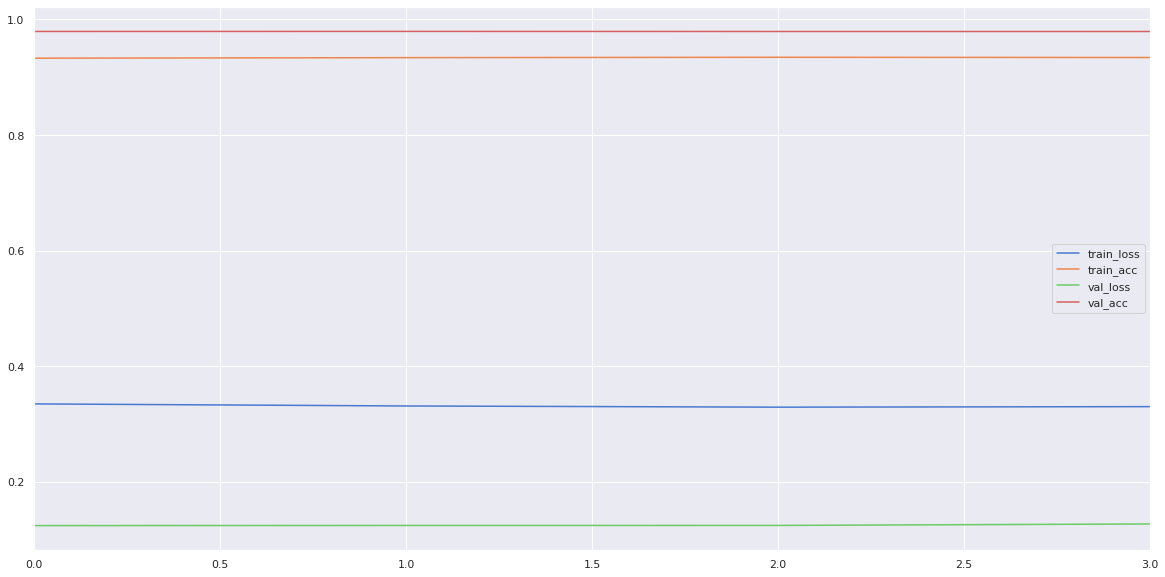

In [35]:
df_history = pd.read_csv('../cache/resnet_history.csv')
fig = plt.figure(figsize=(20, 10))
ax = plt.axes()
# part_history = df_history[["train_loss", "val_loss"]]
df_history.plot(ax=ax)